In [ ]:
from utils.binaries import *
from utils.plotting import *
from utils.Auger.SD import Monit
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from utils import CONSTANTS
import os, shutil

def parabola(x, scale, mip, y0):
    return scale * (x-mip)**2 + y0

def make_histo_fit(counts, p, mode, t=None, version=None):
     
    os.makedirs(f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/", exist_ok=True)
    
    # see Framework/SDetector/Station.h
    match p:
        case 0 | 1 | 2:
            ADC = CONSTANTS.UUB_WCD_PEAK if mode == 'peak' else CONSTANTS.UUB_WCD_CHARGE
        case 3:
            ADC = CONSTANTS.UUB_SSD_PEAK if mode == 'peak' else CONSTANTS.UUB_SSD_CHARGE
    
    bin_change = 100 - 1 if mode == 'peak' else 400 - 1
    try:
        __peak = argrelextrema(counts[:bin_change], np.greater, order=bin_change)[0][0]
        x1, x2, y1, y2 = __peak, bin_change, counts[__peak], counts[bin_change]

        slope, offset = -(np.log(y1)-np.log(y2))/(x2-x1), np.log(y1)
        exp_fit = lambda x: np.exp(slope*(x-x1)+offset)

        guess = np.argmax(counts[__peak:bin_change] - exp_fit(range(__peak, bin_change)))
        start, stop = guess - 6, guess + 25
    
        (curve, mip, height), pcov = curve_fit(parabola, ADC[start:stop], counts[start:stop] - exp_fit(range(start, stop)),
                                        bounds=([-np.inf, 0, 0],[0, np.inf, np.inf]),
                                        maxfev=10000,
                                        p0=[-1, guess, counts[guess]])

        file_loc = f"/cr/data01/filip/plots/DaqIntegrationTest/{version}/pmt{int(p)}/{int(t)}-{mode}.png"
        if not os.path.isfile(file_loc):
            fig = plt.figure()
            plt.plot(ADC, counts)
            plt.axvline(ADC[start], c='k', lw=0.3, ls='--')
            plt.axvline(ADC[stop], c='k', lw=0.3, ls='--')
            plt.plot(ADC[start:stop], exp_fit(range(start, stop)), c='k', ls='--', lw=0.5)
            plt.plot(ADC[start:stop], parabola(ADC[start:stop], curve, mip, height) + exp_fit(range(start, stop)))
            plot.save(fig, f'DaqIntegrationTest/{version}/pmt{int(p)}/{int(t)}-{mode}.png')
            plt.close(fig)

        (_, mip, _) = uncertainties.correlated_values([curve, mip, height], pcov)
        if mip.std_dev / mip.n > 0.1: raise ValueError

        # if mip.n > 300 and mode=='peak': raise ValueError

        return mip.n, mip.std_dev
        
    except Exception as e:

        if not os.path.isfile(f"DaqIntegrationTest/{version}/pmt{int(p)}/failed-{int(t)}-{mode}.png"):
            fig = plt.figure()
            plt.plot(ADC, counts)
            plot.save(fig, f"DaqIntegrationTest/{version}/pmt{int(p)}/failed-{int(t)}-{mode}.png")
            plt.close(fig)

        return np.nan, np.nan

09:27:53 (  +66.9s) [INFO   ] -- received 3 file(s) as input
09:27:54 (  +464ms) [INFO   ] -- View monit keys with self.keys()
09:27:54 (    +8ms) [INFO   ] -- found 422 entries for key fTime and station #609
09:27:54 (   +13ms) [INFO   ] -- found 422 entries for key fPeak and station #609
/cr/users/filip/.venv/lib/python3.10/site-packages/utils/Auger/SD/__init__.py:142: RuntimeWarning: divide by zero encountered in log
  slope, offset = -(np.log(y1)-np.log(y2))/(x2-x1), np.log(y1)
/cr/users/filip/.venv/lib/python3.10/site-packages/utils/Auger/SD/__init__.py:143: RuntimeWarning: invalid value encountered in multiply
  exp_fit = lambda x: np.exp(slope*(x-x1)+offset)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


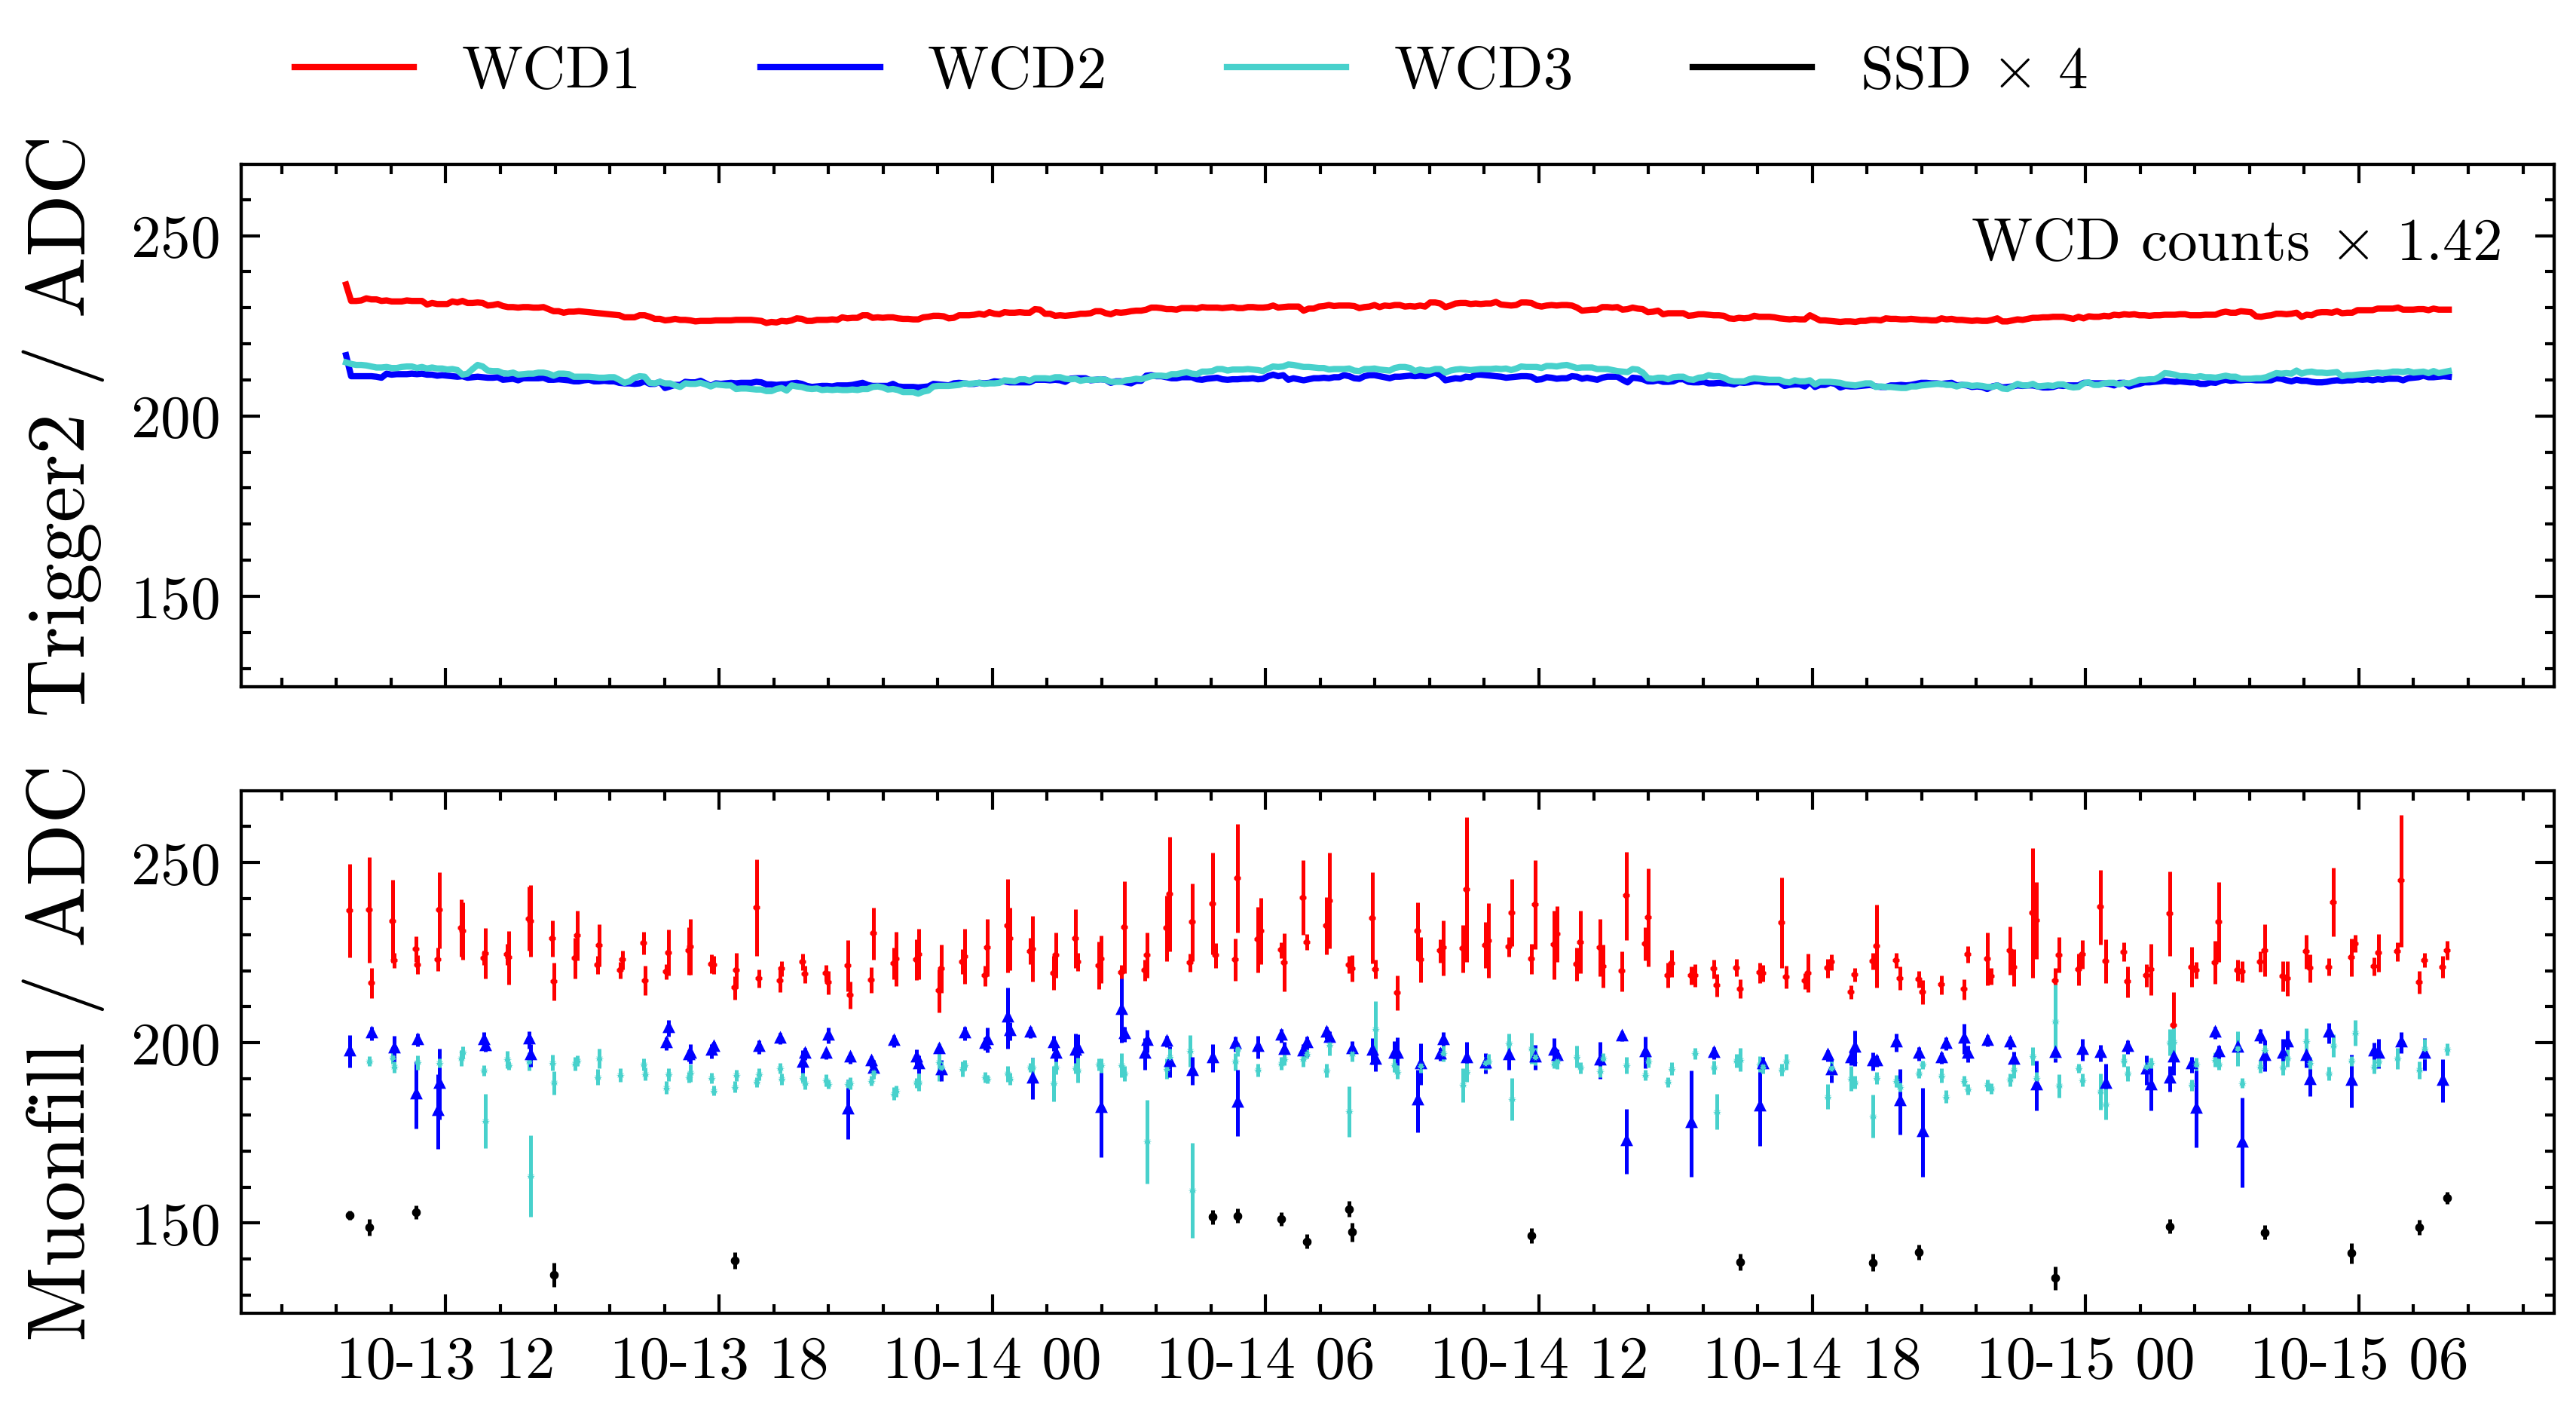

In [4]:
# try:
#     shutil.rmtree('/cr/data01/filip/plots/daqIntegrationTest/v36', )
# except: pass

from utils.binaries import *
from utils.plotting import *
from utils import CONSTANTS

from utils.Auger.SD import SdHisto
from utils.Auger.SD import Monit
import os

errorbar_kwargs = [
    {'marker' : 'x', 'c' : 'r'},
    {'marker' : '^', 'c' : 'b'},
    {'marker' : '*', 'c' : 'mediumturquoise'},
    {'marker' : 'o', 'c' : 'k'},
]

f = 4
version = 'v39'
base = f'/cr/data01/filip/Data/daqIntegrationTests/{version}/'
monit_files = [base + file for file in os.listdir(base) if 'mc' in file]

monit = Monit(*monit_files)
t, wcds = monit('fTime', 609 if version >= 'v36' else 136), monit('fPeak', 609 if version >= 'v36' else 136).T
sort_indices = np.argsort(t)
t, (wcd1, wcd2, wcd3) = t[sort_indices], [w[sort_indices] for w in wcds]
trigger2_inactive_mask = [v!=0 for v in wcd3]

_, t_acq, t_gps, pmt, *phistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/peak.txt', unpack=True)
_,     _,     _,   _, *chistos = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/charge.txt', unpack=True)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)

try:
    t_muonbuffer, mf_wcd1, hz1, mf_wcd2, hz2, mf_wcd3, hz3, ssd, hz4 = np.loadtxt(f'/cr/data01/filip/Data/daqIntegrationTests/{version}/calib.test', unpack=True)
    t_muonbuffer += CONSTANTS.GPS_OFFSET

    ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd1, c='r', ls='solid', lw=0.4)
    ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd2, c='blue', ls='solid', lw=0.4)
    ax2.plot(plot.to_datetime(t_muonbuffer), mf_wcd3, c='mediumturquoise', ls='solid', lw=0.4)
    ax2.plot(plot.to_datetime(t_muonbuffer), ssd * f, c='k')
except:
    # plot.preliminary(ax2, 'No data =(')
    pass

# to convert from filtered & downsampled to full bandwidth
FBW = 1.42

ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd1[trigger2_inactive_mask]*FBW, c='r', label='WCD1', ls='solid')
ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd2[trigger2_inactive_mask]*FBW, c='b', label='WCD2', ls='solid')
ax1.plot(plot.to_datetime(t[trigger2_inactive_mask]), wcd3[trigger2_inactive_mask]*FBW, c='mediumturquoise', label='WCD3', ls='solid')
ax1.plot([],[],c='k', ls='solid', label=rf'SSD $\times$ {f}')


phistos = np.split(np.array(phistos).T, 185)
chistos = np.split(np.array(chistos).T, 185)
t_gps = np.split(t_gps, len(t_gps)/4)

c = ['r', 'b', 'mediumturquoise', 'k']
for i, (tx, chisto, phisto) in enumerate(zip(t_gps, chistos, phistos)):
    histo = SdHisto(peak=phisto, charge=chisto)
    peaks = histo.fit()['peak']

    if not os.path.isfile(f'DaqIntegrationTest/{version}/{int(tx[0])}.png') and not i%5:
        fig = histo.plot()
        plot.save(fig, f'DaqIntegrationTest/{version}/{int(tx[0])}.png')
        fig.clear()
        plt.close(fig)

    for i in range(4):
        factor = 1 if i<3 else f
        ppeak, eerr = peaks[i][1].n * factor, peaks[i][1].std_dev
        ax2.errorbar(plot.to_datetime(tx[0]), ppeak, eerr, ms=0.4, elinewidth=0.6, **errorbar_kwargs[i])

ax1_twin = ax1.twinx()
ax1_twin.legend(title=rf'WCD $\times$ {FBW}')
ax1_twin.set_ylim(*ax1.get_ylim())
ax1_twin.set_yticklabels([])

ax1.set_ylabel("Trigger2 / ADC")
ax2.set_ylabel("Muonfill / ADC")
ax1.legend(bbox_to_anchor=(0, 1.02,1,0.2), loc="lower left", ncol=4)
# ax1.legend(title='Xb')
# ax2.legend(title='MuonFill'

In [ ]:
print(phisto.shape)
print(chisto.shape)

In [ ]:
print()

In [ ]:
print(len(phistos))
print(chisto[0].shape)

In [ ]:
print(len(chistos)/4)

In [ ]:
print(len(chistos))

In [ ]:
print(len(phistos))

In [ ]:
print(len(chistos), len(phistos))

In [ ]:
print(chistos[1])